In [1]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from os import path
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install wordcloud

In [4]:
import findspark
findspark.init()

In [5]:
spark = SparkSession.builder.enableHiveSupport().appName('YelpAnalysis').getOrCreate()
sc = spark.sparkContext
sc.defaultParallelism

24

## Yelp

In [6]:
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.functions import udf

## Data Preparation

In [7]:
df_business = spark.read.json("yelp_academic_dataset_business.json")
df_checkin = spark.read.json("yelp_academic_dataset_checkin.json")
df_review = spark.read.json("yelp_academic_dataset_review.json")
df_tip = spark.read.json("yelp_academic_dataset_tip.json")
df_user = spark.read.json("yelp_academic_dataset_user.json")

In [8]:
df_business.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [9]:
df_business = df_business.withColumnRenamed('stars', 'business_stars')
df_review = df_review.withColumnRenamed('stars', 'review_stars')
df_review = df_review.withColumnRenamed('business_id', 'review_business_id')

In [10]:
df_business_review = df_business.join(df_review, [df_business.business_id == df_review.review_business_id], how = 'inner')
df_business_review.show(5)

+----------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+--------------+-----+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|         address|          attributes|         business_id|          categories|           city|               hours|is_open|  latitude|  longitude|             name|postal_code|review_count|business_stars|state|  review_business_id|cool|               date|funny|           review_id|review_stars|                text|useful|             user_id|
+----------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+--------------+-----+--------------------+----+-------------------+-----+--------------------+------------+---

In [11]:
df_business_review = df_business_review.withColumnRenamed('name', 'business_name')

## Business

In [43]:
category = df_business_review.select('categories')
indi_category = category.select(explode(split('categories', ',')).alias('category'))
group_category = indi_category.groupBy('category').count()
top_category = group_category.sort('count', ascending= False)
top_category.show(10, truncate=False)

+-----------------------+-------+
|category               |count  |
+-----------------------+-------+
| Restaurants           |3532677|
|Restaurants            |1191794|
| Food                  |1186888|
| Nightlife             |1186208|
| Bars                  |1157397|
| American (Traditional)|835517 |
| American (New)        |818246 |
| Breakfast & Brunch    |726605 |
| Sandwiches            |565838 |
| Seafood               |492978 |
+-----------------------+-------+
only showing top 10 rows



In [19]:
top_category = top_category.toPandas()
top_category = top_category[2:12]
top_category

category    count
2                    Nightlife  1309481
3                         Bars  1257102
4                  Restaurants  1191794
5       American (Traditional)   835517
6               American (New)   818246
7           Breakfast & Brunch   726605
8                   Sandwiches   565838
9    Event Planning & Services   501500
10                     Seafood   492978
11                    Shopping   419117

In [12]:
columns_to_drop = ['address','postal_code','latitude','longitude','review_count']
df_business = df_business.drop(*columns_to_drop)

There are altogether 1312 different business categories in Yelp.


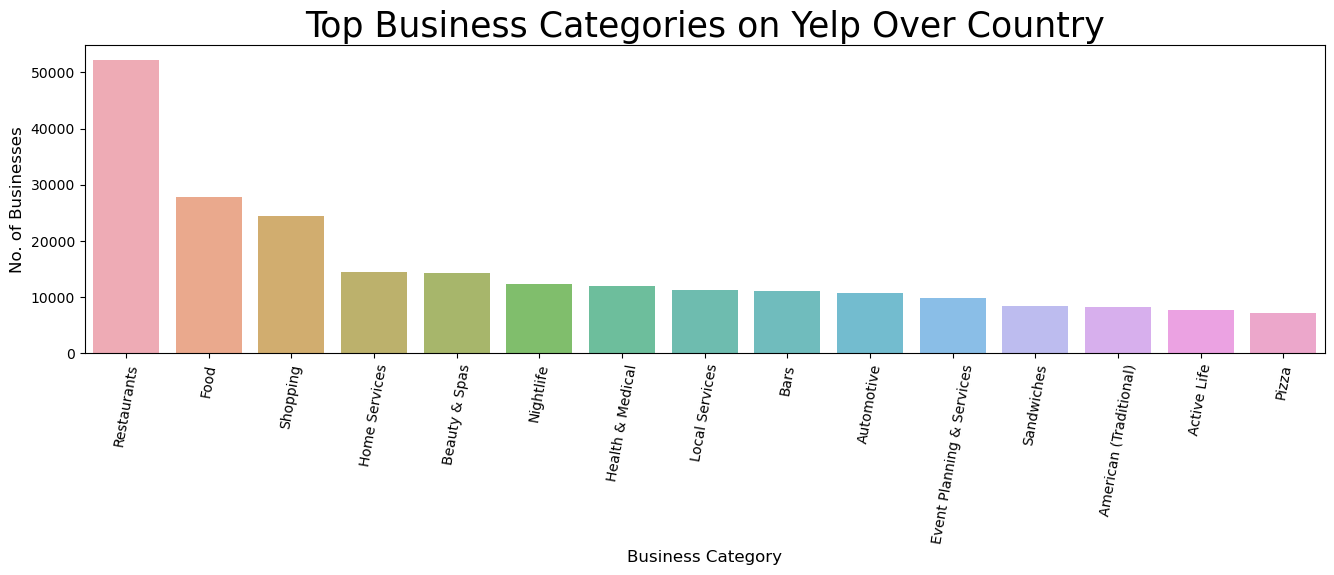

In [13]:
business_pd = df_business.toPandas()

# Prepare data 
category = ",".join([str(business_pd["categories"][i]).replace("[", "").replace("]", "") \
              .replace(", ", ",").replace("'", "") for i in range(len(business_pd))])
b_category = pd.DataFrame(category.split(','), columns=['category'])
category_count = b_category.category.value_counts()
print("There are altogether", len(category_count), "different business categories in Yelp.")

# Prepare to plot the top 15 business categories
category_count = category_count.sort_values(ascending=False)
category_count = category_count.iloc[0:15]
category_count = pd.DataFrame(category_count)
category_count['name'] = category_count.index

# Plot 
plt.figure(figsize = (16,4))
ax = sns.barplot(data=category_count, x="name", y="category", alpha = 0.8)
plt.title("Top Business Categories on Yelp Over Country", fontsize = 25)
loc, labels = plt.xticks()
plt.setp(labels, rotation = 80)
plt.ylabel('No. of Businesses', fontsize = 12)
plt.xlabel('Business Category', fontsize = 12)
 
# Add labels
rectangles = ax.patches
labels = category_count.values
plt.show()

<Axes: ylabel='count'>

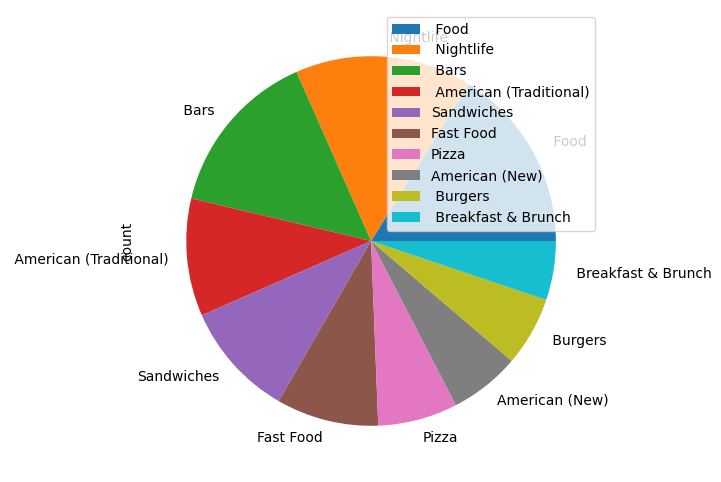

In [20]:
top_category.plot.pie(y='count', labels = [' Food', ' Nightlife', ' Bars',
       ' American (Traditional)','Sandwiches', 'Fast Food', 'Pizza', 'American (New)',
        ' Burgers', ' Breakfast & Brunch'], figsize=(6,6))

In [14]:
df_business.groupBy('is_open').count().show()

+-------+------+
|is_open| count|
+-------+------+
|      0| 30648|
|      1|119698|
+-------+------+



In [44]:
df_business_restaurant = df_business.filter(df_business.categories.contains('Restaurants'))
df_business_review = df_business_review.filter(df_business_review.categories.contains('Restaurants'))

In [39]:
loc = df_business_restaurant.groupBy('state').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
loc.head()

plt.figure(figsize=(11,6))
sns.barplot(data=loc, x="state", y="count", 
            palette=sns.color_palette("Set1"))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('State', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=0)
plt.show()

In [40]:
loc = df_business_restaurant.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
loc = loc.head(10)
loc

city  count
0  Philadelphia   5852
1         Tampa   2960
2  Indianapolis   2862
3     Nashville   2502
4        Tucson   2466
5   New Orleans   2259
6      Edmonton   2166
7   Saint Louis   1790
8          Reno   1286
9         Boise    847

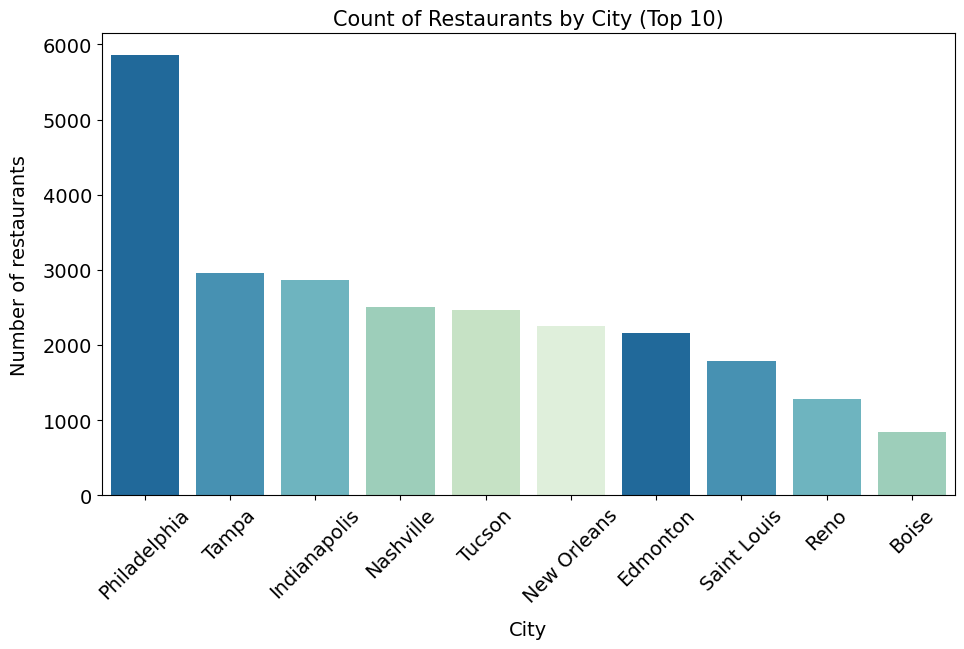

In [41]:
plt.figure(figsize=(11,6))
sns.barplot(data=loc, x="city", y="count", 
            palette=sns.color_palette("GnBu_r"))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45)
plt.show()

## Reviews

In [45]:
df_business_review = df_business_review.withColumn('year', year(df_business_review['date']))
df_business_review = df_business_review.withColumn('month', month(df_business_review['date']))
df_business_review = df_business_review.withColumn("dow_number", date_format('date', 'E').alias('dow_number'))

In [46]:
df_business_review.show(5)

+----------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+--------------+-----+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+----+-----+----------+
|         address|          attributes|         business_id|          categories|           city|               hours|is_open|  latitude|  longitude|    business_name|postal_code|review_count|business_stars|state|  review_business_id|cool|               date|funny|           review_id|review_stars|                text|useful|             user_id|year|month|dow_number|
+----------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+--------------+-----+--------------------+----+-------------------

In [47]:
# Create a Temporary Table
df_business_review.createOrReplaceTempView("yelp")

In [48]:
obw = spark.sql('''select 
  count(review_id) as total_reviews, 
  dow_number as day_of_week 
  from yelp  
 group by dow_number
 order by total_reviews desc''')

In [49]:
obw = obw.toPandas().dropna()
obw.plot(y='total_reviews' , x ='day_of_week', kind='bar', figsize=(11,4), rot=0)

<Axes: xlabel='day_of_week'>

In [50]:
cal_len = udf(lambda x:len(x.split()))

In [51]:
df_1=df_business_review.select('review_stars',cal_len('text'))
df_1 = df_1.withColumnRenamed('<lambda>(text)', 'text_length')

In [52]:
df_1 = df_1.toPandas()
df_1.dtypes
df_1=df_1.astype('int32')

In [53]:
df_1

review_stars  text_length
0                   3          101
1                   3           55
2                   5           40
3                   4           94
4                   1           65
...               ...          ...
4724466             5          169
4724467             5           63
4724468             4          501
4724469             5          378
4724470             3          212

[4724471 rows x 2 columns]

In [54]:
plt.figure(figsize = (20,20))
a = sns.FacetGrid(data =df_1, col = 'review_stars', hue = 'review_stars', palette='plasma')
a.map(sns.distplot, "text_length")
plt.show()

<Figure size 2000x2000 with 0 Axes>

In [55]:
most_five_star = df_business_review.filter(df_business_review.review_stars == 5)
most_five_star_ = most_five_star.groupby('business_name').count().orderBy('count',ascending = 0).toPandas().iloc[0:10]
p= sns.barplot(x="count",y="business_name", data=most_five_star_, linewidth=5)
p.set_xlabel("Five Stars Count", fontsize = 13)
p.set_ylabel("Top 10 Popular Restaurants", fontsize = 13)

Text(0, 0.5, 'Top 10 Popular Restaurants')

Text(0, 0.5, 'Top 10 Popular Restaurants in IL')

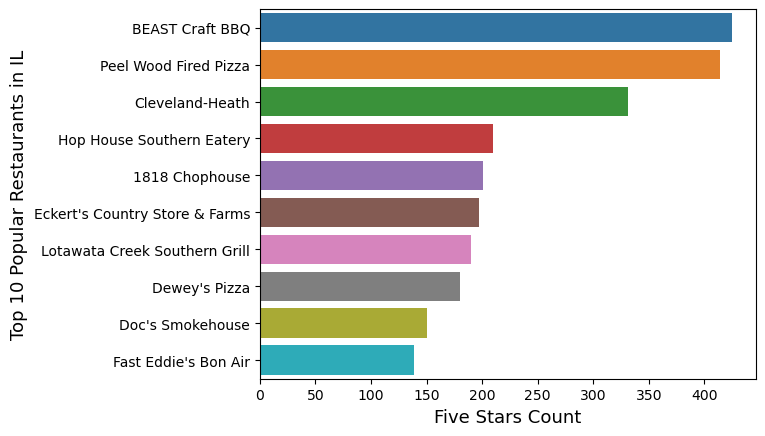

In [56]:
most_five_star_il = df_business_review.filter((df_business_review.review_stars == 5) & (df_business_review.state == 'IL'))
most_five_star_il_ = most_five_star_il.groupby('business_name').count().orderBy('count',ascending = 0).toPandas().iloc[0:10]
p= sns.barplot(x="count",y="business_name", data=most_five_star_il_, linewidth=5)
p.set_xlabel("Five Stars Count", fontsize = 13)
p.set_ylabel("Top 10 Popular Restaurants in IL", fontsize = 13)

Text(0, 0.5, 'Top 10 Worst Restaurants')

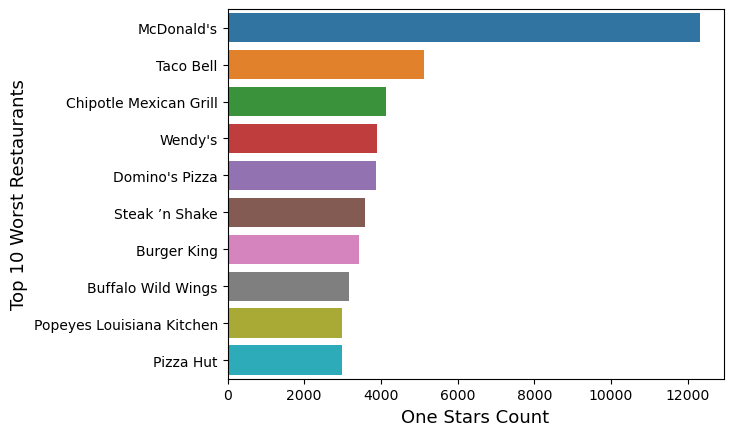

In [57]:
most_one_star = df_business_review.filter(df_business_review.review_stars == 1)
most_one_star_ = most_one_star.groupby('business_name').count().orderBy('count',ascending = 0).toPandas().iloc[0:10]
p= sns.barplot(x="count",y="business_name", data=most_one_star_, linewidth=5)
p.set_xlabel("One Stars Count", fontsize = 13)
p.set_ylabel("Top 10 Worst Restaurants", fontsize = 13)

Text(0, 0.5, 'Top 10 Worst Restaurants in IL')

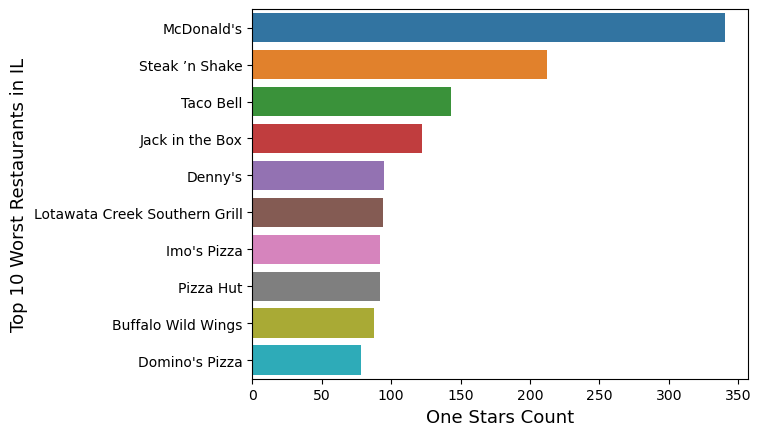

In [58]:
most_one_star_il = df_business_review.filter((df_business_review.review_stars == 1) & (df_business_review.state == 'IL'))
most_one_star_il_ = most_one_star_il.groupby('business_name').count().orderBy('count',ascending = 0).toPandas().iloc[0:10]
p= sns.barplot(x="count",y="business_name", data=most_one_star_il_, linewidth=5)
p.set_xlabel("One Stars Count", fontsize = 13)
p.set_ylabel("Top 10 Worst Restaurants in IL", fontsize = 13)

## Users

In [59]:
df_business_review = df_business_review.select('business_id', 'city', 'business_name', 'review_count', 'business_stars', 'review_business_id', 'review_id', 'review_stars', 'text', 'useful', 'user_id')

In [60]:
df_user = df_user.withColumnRenamed('name', 'user_name')

In [62]:
df_user.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|user_name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         

In [63]:
df_business_review_user = df_business_review.join(df_user,on ='user_id', how = 'inner')

In [64]:
df_business_review_user.show(5)

+--------------------+--------------------+--------------+--------------------+------------+--------------+--------------------+--------------------+------------+--------------------+------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------------+------------+------+-------------------+
|             user_id|         business_id|          city|       business_name|review_count|business_stars|  review_business_id|           review_id|review_stars|                text|useful|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|    user_name|review_count|useful|      yelping_since|
+--------------------+------

In [65]:
df_user_count = df_business_review_user.groupBy('user_name', 'user_id').count().sort(desc('count')).toPandas()
df_user_count = df_user_count.head(10)

In [66]:
df_user_count

user_name                 user_id  count
0     Karen  _BcWyKQL16ndpBdggh2kNA   1704
1    Gerald  -G7Zkl1wIWBBmD0KRy_sCw   1297
2  Michelle  ET8n-r7glWYqZhuR6GcdNw   1144
3      Boon  fr1Hz2acAb3OaL3l6DyKNg   1104
4   Shannon  1HM81n6n4iPIFU5d2Lokhw   1095
5    Steven  bYENop4BuQepBjM1-BI3fA    987
6  Marielle  Xw7ZjaGfr0WNVt6s_5KZfA    971
7     Danan  ouODopBKF3AqfCkuQEnrDg    956
8      Mark  VL12EhEdT4OWqGq0nIqkzw    901
9     Brett  pou3BbKsIozfH50rxmnMew    898

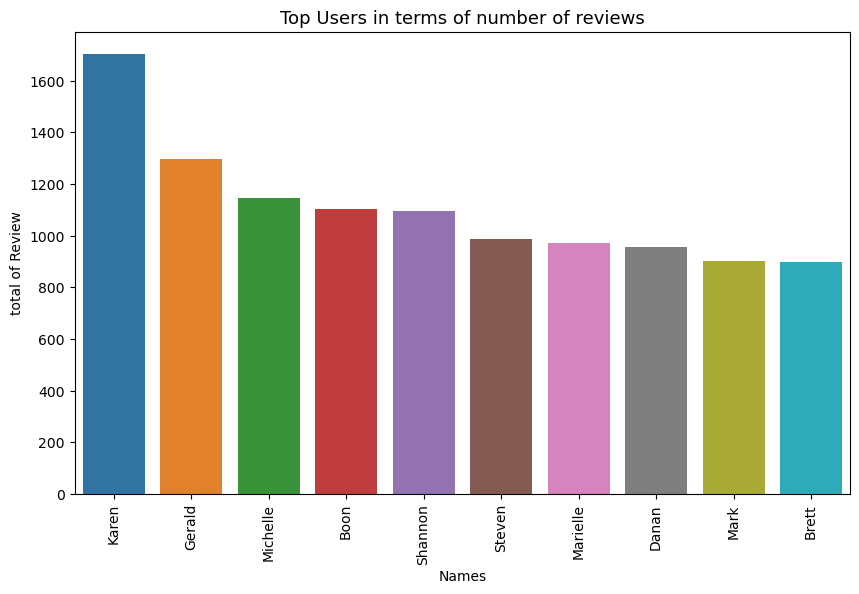

In [67]:
plt.figure(figsize=(10,6))
sns.barplot(x='user_name', y='count', data=df_user_count)
plt.title("Top Users in terms of number of reviews", fontsize=13)
plt.xlabel("Names", fontsize = 10)
plt.ylabel("total of Review", fontsize = 10)
plt.xticks(rotation=90)
plt.show()

## Analysis

We want to consider two questions.

**Firstly, do all the users send reviews on Yelp after they experienced the service or only very satisfied or unsatisfied experiences would make users comment on Yelp?**

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

If the skew is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If skew is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [68]:
df_review.show(10)

+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|  review_business_id|cool|               date|funny|           review_id|review_stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|         3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|         5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|         3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:

In [70]:
df_review_notnull = df_review.where(F.col("text").isNotNull())
df_review_notnull1 = df_review_notnull.select('review_business_id','review_stars')
df_review_notnull1.show(5)

+--------------------+------------+
|  review_business_id|review_stars|
+--------------------+------------+
|XQfwVwDr-v0ZS3_Cb...|         3.0|
|7ATYjTIgM3jUlt4UM...|         5.0|
|YjUWPpI6HXG530lwP...|         3.0|
|kxX2SOes4o-D3ZQBk...|         5.0|
|e4Vwtrqf-wpJfwesg...|         4.0|
+--------------------+------------+
only showing top 5 rows



In [72]:
df_review_notnull2 = df_review_notnull1.groupBy('review_business_id').agg(F.avg('review_stars').alias('avstars'))
df_review_notnull2.show(5)

+--------------------+------------------+
|  review_business_id|           avstars|
+--------------------+------------------+
|WKMJwqnfZKsAae75R...|             3.825|
|sk2lZI4zmuGAccd3D...| 4.757575757575758|
|zJErbOQMKX-MwHs_u...|2.9279279279279278|
|NQhyMw8SOU1HB-V9X...|              2.62|
|neL2xrin-uMJl5ABK...| 3.611111111111111|
+--------------------+------------------+
only showing top 5 rows



In [74]:
df_avr = df_business.join(df_review_notnull2, df_business.business_id == df_review_notnull2.review_business_id).select('avstars','business_stars','name','city','state').sort(F.desc("business_stars"))
df_avr.show(5)

+-----------------+--------------+--------------------+-------------+-----+
|          avstars|business_stars|                name|         city|state|
+-----------------+--------------+--------------------+-------------+-----+
|              5.0|           5.0|Pediatric Dentist...|        Tampa|   FL|
|              5.0|           5.0|Head & Heart Phot...|Santa Barbara|   CA|
|4.885714285714286|           5.0|Discount Door Ser...|       Tucson|   AZ|
|4.864864864864865|           5.0|The Inn at Bowman...|     New Hope|   PA|
|              5.0|           5.0|      XO Hair N Lash|       Tucson|   AZ|
+-----------------+--------------+--------------------+-------------+-----+
only showing top 5 rows



In [75]:
df_avr = df_avr.withColumn('skew', (df_avr.avstars - df_avr.business_stars))
df_avr.show(5)

+-----------------+--------------+--------------------+---------------+-----+--------------------+
|          avstars|business_stars|                name|           city|state|                skew|
+-----------------+--------------+--------------------+---------------+-----+--------------------+
|4.833333333333333|           5.0|         HQ Salonspa|  Sherwood Park|   AB|-0.16666666666666696|
|              5.0|           5.0|          Hair Force|New Port Richey|   FL|                 0.0|
|              5.0|           5.0|    Top Hat Espresso|   Philadelphia|   PA|                 0.0|
|4.916666666666667|           5.0|         Dan Brassil|    Saint Louis|   MO|-0.08333333333333304|
|              5.0|           5.0|Graham Stone Brew...|      Nashville|   TN|                 0.0|
+-----------------+--------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows



In [76]:
df_avr_pd = df_avr.toPandas()

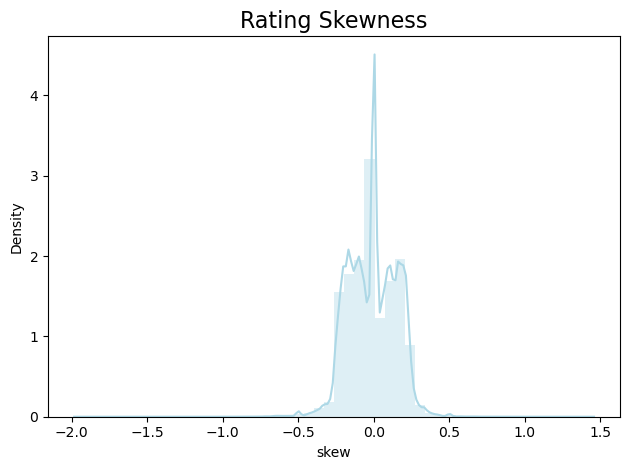

In [77]:
plt.clf()
sns.distplot(df_avr_pd['skew'], hist = True, color = 'lightblue')
plt.title('Rating Skewness', size = 16)
plt.tight_layout()
plt.show()

The graph seems to be positively skewed, however the skewness is not very noticable. So we need to run a statistical test.

In [78]:
df_avr_pd.head()

avstars  business_stars                           name              city  \
0  4.757576             5.0      Boyd Hill Nature Preserve  Saint Petersburg   
1  5.000000             5.0                     Wanderwell      Philadelphia   
2  4.964286             5.0                Mission Tuxedos     Santa Barbara   
3  4.750000             5.0  Diamond Lil's Vintage & Gifts            Tucson   
4  4.880000             5.0                   Just Churros            Tucson   

  state      skew  
0    FL -0.242424  
1    PA  0.000000  
2    CA -0.035714  
3    AZ -0.250000  
4    AZ -0.120000

In [79]:
from scipy import stats

In [80]:
shapiro_test = stats.shapiro(df_avr_pd['skew'])
shapiro_test

ShapiroResult(statistic=0.9810457229614258, pvalue=0.0)

In [81]:
log_avr = np.log(df_avr_pd['skew'].values + 1)

In [82]:
log_avr

array([-0.27763174,  0.        , -0.03636764, ...,  0.        ,
        0.        ,  0.15415068])

In [83]:
shapiro_test1 = stats.shapiro(log_avr)
shapiro_test1

ShapiroResult(statistic=nan, pvalue=1.0)

In [84]:
res = stats.wilcoxon(df_avr_pd['skew'].values)
res.pvalue

3.472651125998972e-95

This implies that the mean of rating by user with text review submitted are different from the average rating by all users. In this case, average rating is lower than the other.

**Secondly, how do we differentiate those bad reviews, such as reviews from competitors?**

Elite users in Yelp means they are more trustworthy than usual users. If we want to conduct further modeling, should we use all the reviews data or only reviews from Elite members?

Equivalently, we can conduct the same test to show if there are significant differences between elite reviews and non-elite reviews.

In [85]:
df_user_elite = df_user.filter("elite != ''")
df_user_nonelite = df_user.filter("elite == ''")

In [86]:
df_user_nonelite.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|user_name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         3.54|              0|              0|           

In [87]:
df_user_review_elite = df_user_elite.join(df_review, df_user_elite.user_id == df_review.user_id).select('review_stars')
df_user_review_elite.show(5)

+------------+
|review_stars|
+------------+
|         4.0|
|         4.0|
|         3.0|
|         5.0|
|         5.0|
+------------+
only showing top 5 rows



In [88]:
df_user_review_nonelite = df_user_nonelite.join(df_review, df_user_nonelite.user_id == df_review.user_id).select('review_stars')
df_user_review_nonelite.show(5)

+------------+
|review_stars|
+------------+
|         5.0|
|         1.0|
|         4.0|
|         4.0|
|         2.0|
+------------+
only showing top 5 rows



In [90]:
df_user_review_elite_pd = df_user_review_elite.toPandas()
df_user_review_nonelite_pd = df_user_review_nonelite.toPandas()

In [91]:
df_user_review_elite_pd

review_stars
0                 4.0
1                 4.0
2                 3.0
3                 5.0
4                 5.0
...               ...
1725653           4.0
1725654           5.0
1725655           5.0
1725656           4.0
1725657           5.0

[1725658 rows x 1 columns]

In [92]:
stats.shapiro(df_user_review_elite_pd['review_stars'].values)

ShapiroResult(statistic=0.818276047706604, pvalue=0.0)

In [93]:
stats.shapiro(df_user_review_nonelite_pd['review_stars'].values)

ShapiroResult(statistic=0.738956868648529, pvalue=0.0)

For unequal sample size, we use Kruskal-Wallis H-test

In [94]:
stats.kruskal(df_user_review_elite_pd['review_stars'].values, df_user_review_nonelite_pd['review_stars'].values)

KruskalResult(statistic=1432.5370914340867, pvalue=0.0)

The differences are significant.

Users are mostly driven to post a review on Yelp when they are very satisfied with the experience they have with these businesses (ratings = 5 and 4). It is also interesting to note that the next star rating with the most count after the two most positive ratings is the most negative rating, i.e. 1. These observations make sense, as customers/ users tend to get motivated by the good experience that they have to write something in support of the businesses. At the same time, when a customer experiences something very negative, one of the best mediums to vent their frustration/ disappointment is by writing a negative review either to warn others, or to provide feedback to the businesses, so that they would not need to experience something similar again.

Before we dive into our first main analysis which is to perform sentiment classification, we first select a subset of the reviews for analysis. Below are our key selection features and the reason behind our selection decisions:

1. Only select reviews for restaurant businesses
Here, we are interested in identifying factors that drive users' reviews - be it positive or negative, and we are particularly interested in the restaurant businesses, which as seen in the first plot above, is the most prominent business type on Yelp.

Since our aim is to identify words/ group of words that users associate with positive/ negative sentiment, it is better to look at a specific business type, as different business types may have different aspects that users are happy/ unhappy with. To illustrate, we would expect a review on a food business to be very different from a review on say, a spa business. There are different general expectations across different business types, and if we were to look at them all together, we would not be able to extract much useful information, as they would all be mixed.

2. Only select reviews that are labelled as useful by at least one user
As the nature of reviews is such that there may be fake reviews, or reviews that do not make sense, here we are going to filter the dataset to only analyse reviews that have been rated as useful by at least one other user. This will help us to focus more on the aspects of reviews that are deemed useful.

3. Only select positive reviews (rated as 4 or 5 stars) and negative reviews (rated as 1 or 2 stars), exclude neutral reviews (rated as 3 stars)
From the distribution of star ratings (the plot above), we inferred that majority of users will be motivated to write reviews if they are very pleased/ very dissatisfied with the businesses. At the same time, neutral reviews are typically not associated with strong positive/ negative sentiments - they are usually customers who like certain aspects of the business and dislike some other aspects of the business.